In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import matplotlib.ticker as mticker

In [ ]:
# Cell Growth and Antibiotic Influx Parameters
L0 = 10.0            # Initial length of the cell (µm)
k_in = 0.05          # Influx rate of antibiotic into the periplasmic space (per unit time)
k_L = 0.05           # Growth rate constant for cell elongation (µm/unit time)
A_ext = 40.0         # Fixed concentration of antibiotic in the environment (µg/mL)
r_outer = 0.5        # Outer radius of the cell (µm)
r_inner = 0.45       # Inner radius of the cell (µm)
A_int0 = 0.0         # Initial antibiotic concentration in the periplasmic space (µg/mL)

# Exposure Timing Parameters
antibiotic_introduction_time = 20  # Time when antibiotic is introduced and filamentation begins (time units)
total_simulation_time = 100        # Total time for the simulation after antibiotic introduction (time units)

# Survival Analysis Parameters for Dose-Response Curves
external_concentrations = np.linspace(10, 80, 20)  # Range of antibiotic concentrations (doses) to test (µg/mL)
lethal_threshold = 20                             # Threshold concentration to consider cell as "killed" (µg/mL)

# Parameters for Stochastic Variation in Survival Analysis
k_in_mean = 0.05        # Mean antibiotic influx rate for stochastic simulation
k_in_std = 0.01         # Standard deviation for antibiotic influx rate
num_trials = 100         # Number of trials per dose in the survival analysis

# Simulation and ODE Solver Parameters
t_span = (0, total_simulation_time)                     # Time span for the simulation (start, end)
t_eval = np.linspace(t_span[0], t_span[1], 500)         # Time points at which to evaluate the solution


In [ ]:
# Function to calculate periplasmic volume based on cell length L
def calculate_periplasmic_volume(L, r_outer, r_inner):
    cylindrical_volume = np.pi * (r_outer**2 - r_inner**2) * L
    hemispherical_volume = (4/3) * np.pi * (r_outer**3 - r_inner**3)
    return cylindrical_volume + hemispherical_volume

# Function to calculate periplasmic surface area based on cell length L
def calculate_periplasmic_surface_area(L, r_outer, r_inner):
    cylindrical_area = 2 * np.pi * (r_outer - r_inner) * L
    hemispherical_area = 4 * np.pi * (r_outer**2 - r_inner**2)
    return cylindrical_area + hemispherical_area

# Define model with conditional filamentation
def model_with_switch(t, y, k_in, filamentation_start):
    L, A_int = y
    V_peri = calculate_periplasmic_volume(L, r_outer, r_inner)

    # Allow filamentation only after antibiotic is introduced
    dL_dt = k_L * L if t >= filamentation_start else 0

    # Antibiotic dynamics in the periplasm
    dA_int_dt = k_in * (A_ext - A_int) - (A_int / V_peri) * (dL_dt * np.pi * (r_outer**2 - r_inner**2))

    return [dL_dt, dA_int_dt]

# Null case: constant length, no filamentation
def model_null_case_with_switch(t, A_int, k_in):
    V_peri_constant = calculate_periplasmic_volume(L0, r_outer, r_inner)
    dA_int_dt = k_in * (A_ext - A_int)  # No dilution effect, since L is constant
    return dA_int_dt


In [ ]:
# Parameters
t_span_pre = (0, antibiotic_introduction_time)
t_span_exposure = (antibiotic_introduction_time, antibiotic_introduction_time + total_simulation_time)
t_eval_pre = np.linspace(t_span_pre[0], t_span_pre[1], 100)
t_eval_exposure = np.linspace(t_span_exposure[0], t_span_exposure[1], 400)

# Initial conditions and function for calculating periplasmic volume and surface area
y0 = [L0, A_int0]

# Phase 1: Pre-exposure simulation (k_in = 0)
solution_pre = solve_ivp(lambda t, y: model_with_switch(t, y, k_in=0, filamentation_start=antibiotic_introduction_time),
                         t_span_pre, y0, t_eval=t_eval_pre, method='RK45')

# Phase 2: Exposure simulation with antibiotic (regular k_in)
y0_exposure = [solution_pre.y[0, -1], solution_pre.y[1, -1]]  # Start from the end of pre-exposure
solution_exposure = solve_ivp(lambda t, y: model_with_switch(t, y, k_in=k_in, filamentation_start=antibiotic_introduction_time),
                              t_span_exposure, y0_exposure, t_eval=t_eval_exposure, method='RK45')

# Concatenate the pre-exposure and exposure solutions
t_combined = np.concatenate((solution_pre.t, solution_exposure.t))
L_values = np.concatenate((solution_pre.y[0], solution_exposure.y[0]))
A_int_values = np.concatenate((solution_pre.y[1], solution_exposure.y[1]))

# Calculate volume and SA:V ratio for the combined solution
V_peri_values = calculate_periplasmic_volume(L_values, r_outer, r_inner)
SA_values = calculate_periplasmic_surface_area(L_values, r_outer, r_inner)
SA_to_V_ratio = SA_values / V_peri_values


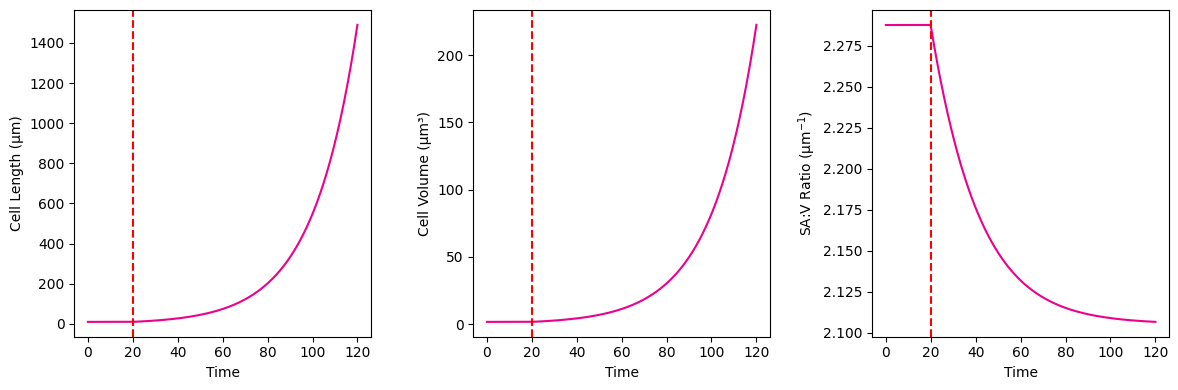

In [ ]:
# Plotting: Cell length, volume, and SA:V ratio over time with pre-exposure phase
plt.figure(figsize=(12, 4))

# Cell Length over time plot
plt.subplot(1, 3, 1)
plt.plot(t_combined, L_values, color='#EC008C')
plt.axvline(x=antibiotic_introduction_time, color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cell Length (µm)")

# Volume over time plot
plt.subplot(1, 3, 2)
plt.plot(t_combined, V_peri_values, color='#EC008C')
plt.axvline(x=antibiotic_introduction_time, color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Cell Volume (µm³)")

# SA:V ratio over time plot
plt.subplot(1, 3, 3)
plt.plot(t_combined, SA_to_V_ratio, color='#EC008C')
plt.axvline(x=antibiotic_introduction_time, color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("SA:V Ratio (µm$^{-1}$)")

plt.tight_layout()
plt.show()


**Figure [X]**: Dynamics of cell morphology and surface area-to-volume (SA:V) ratio during pre-exposure and exposure to antibiotic.  
(**A**) Cell length ($L$) over time, with a marked increase following the introduction of the antibiotic at $t = 20$ (red dashed line), demonstrating filamentation.  
(**B**) Periplasmic volume ($V_{\text{peri}}$) shows steady growth during pre-exposure, followed by accelerated expansion post-antibiotic introduction, reflecting continued elongation.  
(**C**) SA:V ratio over time; a rapid decline post-exposure indicates an increase in cell volume relative to surface area, driven by filamentation.


In [ ]:
# Initial conditions
y0 = [L0, A_int0]

# Solve ODE with filamentation only after the antibiotic is introduced
solution = solve_ivp(lambda t, y: model_with_switch(t, y, k_in=(0 if t < antibiotic_introduction_time else k_in),
                                                    filamentation_start=antibiotic_introduction_time),
                     t_span, y0, t_eval=t_eval, method='RK45')

# Extract cell length (L) and antibiotic concentration (A_int) over time
t_values = solution.t
L_values = solution.y[0]
A_int_values = solution.y[1]

# Solve null case without filamentation, but with antibiotic introduction at antibiotic_introduction_time
solution_null = solve_ivp(lambda t, A_int: model_null_case_with_switch(t, A_int, k_in=(0 if t < antibiotic_introduction_time else k_in)),
                          t_span, [A_int0], t_eval=t_eval, method='RK45')
A_int_values_null = solution_null.y[0]

# Define the lethal threshold for antibiotic concentration
lethal_threshold = 20

# Function to find the kill time (first time A_int reaches lethal threshold)
def find_kill_time(t_values, A_int_values, threshold):
    for t, A in zip(t_values, A_int_values):
        if A >= threshold:
            return t
    return None  # Return None if threshold is never reached

# Compute kill times for both cases
kill_time_filamentation = find_kill_time(t_values, A_int_values, lethal_threshold)
kill_time_null_case = find_kill_time(solution_null.t, A_int_values_null, lethal_threshold)

# Display the kill times
print(f"Kill time with filamentation: {kill_time_filamentation} time units")
print(f"Kill time without filamentation (null case): {kill_time_null_case} time units")

# Calculate SA and V_peri values over time for both cases
SA_values_filamentation = calculate_periplasmic_surface_area(L_values, r_outer, r_inner)
V_peri_values_filamentation = calculate_periplasmic_volume(L_values, r_outer, r_inner)
SA_to_V_ratio_filamentation = SA_values_filamentation / V_peri_values_filamentation

SA_values_null = calculate_periplasmic_surface_area(np.full_like(solution_null.t, L0), r_outer, r_inner)
V_peri_values_null = calculate_periplasmic_volume(np.full_like(solution_null.t, L0), r_outer, r_inner)
SA_to_V_ratio_null = SA_values_null / V_peri_values_null


Kill time with filamentation: 70.74148296593187 time units
Kill time without filamentation (null case): 33.86773547094189 time units


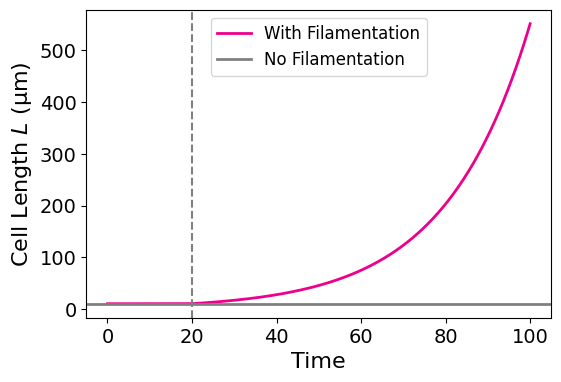

In [ ]:
# Panel A: Cell length (L) over time with the null case length as a dotted line
plt.figure(figsize=(6, 4))
plt.plot(t_values, L_values, label="With Filamentation", color='#EC008C', lw=2)
plt.axhline(y=L0, color='grey', linestyle='-', label="No Filamentation", lw=2)
plt.axvline(x=antibiotic_introduction_time, color='grey', linestyle='--')
plt.xlabel("Time", fontsize=16)
plt.ylabel("Cell Length $L$ (µm)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.show()




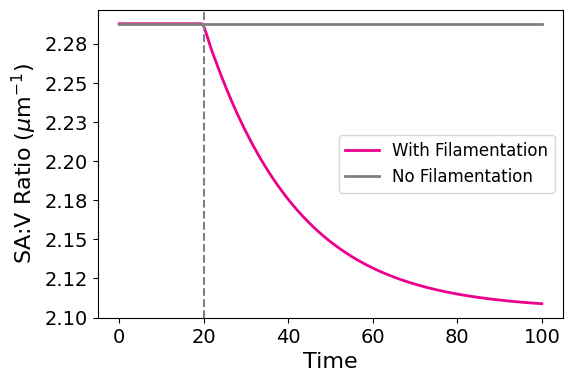

In [ ]:

# Panel B: SA:V ratio over time for both cases
plt.figure(figsize=(6, 4))
plt.plot(t_values, SA_to_V_ratio_filamentation, color='#EC008C', label="With Filamentation", lw=2)
plt.plot(solution_null.t, SA_to_V_ratio_null, color='grey', linestyle='-', label="No Filamentation", lw=2)
plt.axvline(x=antibiotic_introduction_time, color='grey', linestyle='--')
plt.xlabel("Time", fontsize=16)
plt.ylabel("SA:V Ratio ($\mu$m$^{-1}$)", fontsize=16)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.show()



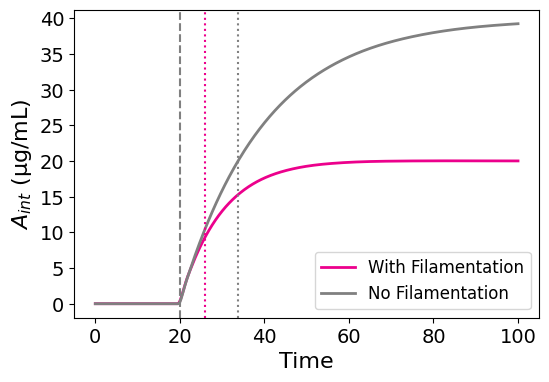

In [ ]:


# Panel C: Antibiotic concentration (A_int) over time for both cases, with kill time marked
plt.figure(figsize=(6, 4))
plt.plot(t_values, A_int_values, color='#EC008C', label="With Filamentation", lw=2)
plt.plot(solution_null.t, A_int_values_null, color='grey', linestyle='-', label="No Filamentation", lw=2)
plt.axvline(x=antibiotic_introduction_time, color='grey', linestyle='--')
if kill_time_filamentation:
    plt.axvline(x=kill_time_filamentation, color='#EC008C', linestyle=':')
if kill_time_null_case:
    plt.axvline(x=kill_time_null_case, color='grey', linestyle=':')
plt.xlabel("Time", fontsize=16)
plt.ylabel("$A_{int}$ (µg/mL)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.show()

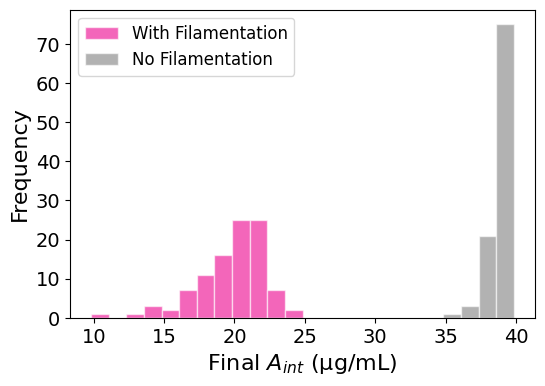

In [ ]:


# Storage for final antibiotic concentrations
final_concentrations_filamentation = []
final_concentrations_null = []

# Function to run each trial and return the final internal concentration
def compute_final_concentration(A_ext, filamentation):
    # Randomly sample `k_in` for each trial
    k_in = np.random.normal(k_in_mean, k_in_std)
    if filamentation:
        # Filamentation case
        solution = solve_ivp(
            lambda t, y: model_with_switch(t, y, k_in=(0 if t < antibiotic_introduction_time else k_in),
                                           filamentation_start=antibiotic_introduction_time),
            (0, 100), [L0, A_int0], t_eval=np.linspace(0, 100, 500), method='RK45')
        return solution.y[1, -1]  # Return the final A_int value
    else:
        # Null case (no filamentation, constant cell length)
        solution_null = solve_ivp(
            lambda t, A_int: model_null_case_with_switch(t, A_int, k_in=(0 if t < antibiotic_introduction_time else k_in)),
            (0, 100), [A_int0], t_eval=np.linspace(0, 100, 500), method='RK45')
        return solution_null.y[0, -1]  # Return the final A_int value

# Run multiple trials and collect final concentrations for filamentation and null cases
for _ in range(num_trials):
    final_concentration_filamentation = compute_final_concentration(lethal_threshold, filamentation=True)
    final_concentration_null = compute_final_concentration(lethal_threshold, filamentation=False)
    final_concentrations_filamentation.append(final_concentration_filamentation)
    final_concentrations_null.append(final_concentration_null)

# Determine the combined range of final concentrations and create consistent bins
all_final_concentrations = final_concentrations_filamentation + final_concentrations_null
bins = np.linspace(min(all_final_concentrations), max(all_final_concentrations), 25)

# Plot histograms for the final internal concentrations with consistent bins
plt.figure(figsize=(6, 4))

# Filamentation case histogram
plt.hist(final_concentrations_filamentation, bins=bins, color='#EC008C', alpha=0.6, label="With Filamentation", edgecolor='white')

# Null case histogram
plt.hist(final_concentrations_null, bins=bins, color='grey', alpha=0.6, label="No Filamentation", edgecolor='white')

# Labels and legend
plt.xlabel("Final $A_{int}$ (µg/mL)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


**(E)** Histogram of final periplasmic antibiotic concentrations ($A_{\text{int}}$) after exposure, comparing filamenting and non-filamenting (null) cases. Filamentation trials exhibit a broader distribution of final $A_{\text{int}}$ values, indicating greater variability in antibiotic uptake across the population. In the null case, where cell length remains constant, the final $A_{\text{int}}$ distribution is narrower, suggesting more uniform antibiotic accumulation. This variability in the filamentation case illustrates the role of filamentation in diversifying internal antibiotic levels across the population, potentially contributing to differential survival under antibiotic stress.

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


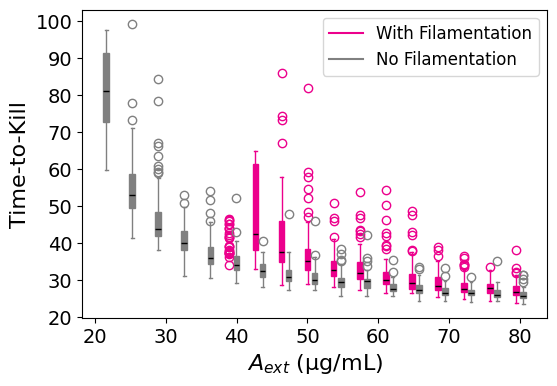

In [ ]:
# Function to calculate time-to-kill for a given dose and case with stochastic `k_in`
def compute_kill_time(A_ext, filamentation):
    # Randomly sample `k_in` for each simulation, keeping `L0` fixed
    k_in = np.random.normal(k_in_mean, k_in_std)

    if filamentation:
        # Filamentation case
        solution = solve_ivp(
            lambda t, y: model_with_switch(t, y, k_in=(0 if t < antibiotic_introduction_time else k_in),
                                           filamentation_start=antibiotic_introduction_time),
            t_span, [L0, A_int0], t_eval=t_eval, method='RK45')
        t_values, A_int_values = solution.t, solution.y[1]
    else:
        # Null case (no filamentation, constant cell length)
        solution_null = solve_ivp(
            lambda t, A_int: model_null_case_with_switch(t, A_int, k_in=(0 if t < antibiotic_introduction_time else k_in)),
            t_span, [A_int0], t_eval=t_eval, method='RK45')
        t_values, A_int_values = solution_null.t, solution_null.y[0]

    # Find the first time the concentration reaches the lethal threshold
    for t, A_int in zip(t_values, A_int_values):
        if A_int >= lethal_threshold:
            return t
    return np.inf  # Return infinity if the lethal concentration is never reached

# Data collection for dose-response with stochastic effects
kill_times_filamentation = []
kill_times_null = []

# Loop over external concentrations and run multiple trials for each dose
for A_ext in external_concentrations:
    trial_kill_times_filamentation = []
    trial_kill_times_null = []

    # Run multiple trials for each dose
    for _ in range(num_trials):
        # Calculate time-to-kill for filamentation and null cases
        kill_time_filamentation = compute_kill_time(A_ext, filamentation=True)
        kill_time_null = compute_kill_time(A_ext, filamentation=False)

        # Append results
        trial_kill_times_filamentation.append(kill_time_filamentation)
        trial_kill_times_null.append(kill_time_null)

    # Append each trial result to overall lists
    kill_times_filamentation.append(trial_kill_times_filamentation)
    kill_times_null.append(trial_kill_times_null)

# Offset positions for side-by-side plotting
positions_filamentation = external_concentrations - 0.5  # Shift left
positions_null = external_concentrations + 0.5           # Shift right

# Plotting the dose-response as a distribution of time-to-kill values
plt.figure(figsize=(6, 4))

# Box plot for filamentation
plt.boxplot(kill_times_filamentation, positions=positions_filamentation, widths=0.8,
            patch_artist=True, boxprops=dict(facecolor="#EC008C", color="#EC008C"),
            medianprops=dict(color="black"), whiskerprops=dict(color="#EC008C"),
            capprops=dict(color="#EC008C"), flierprops=dict(markeredgecolor="#EC008C"),
            showfliers=True, manage_ticks=False)

# Box plot for no filamentation (null case)
plt.boxplot(kill_times_null, positions=positions_null, widths=0.8,
            patch_artist=True, boxprops=dict(facecolor="grey", color="grey"),
            medianprops=dict(color="black"), whiskerprops=dict(color="grey"),
            capprops=dict(color="grey"), flierprops=dict(markeredgecolor="grey"),
            showfliers=True, manage_ticks=False)

# Manually add legend entries
plt.plot([], [], color="#EC008C", label="With Filamentation")  # #EC008C placeholder
plt.plot([], [], color="grey", label="No Filamentation")      # Grey placeholder

# Labels and legend
plt.xlabel("$A_{ext}$ (µg/mL)", fontsize=16)
plt.ylabel("Time-to-Kill", fontsize=16)
plt.legend(loc="upper right", fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
